In [1]:
import pandas as pd
import numpy as np

from utils import process_data, compare_models, read_batched_data

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import make_scorer, roc_auc_score

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import pickle

import matplotlib.pyplot as plt

from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dict = process_data('normal', folds = 5)

  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

Beginning data processing ...
Reading in batched data ...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.43it/s]


Splitting data into train and test ...
Scaling data ...
Completed normal data processing.


## Logit Model

In [2]:
roc = make_scorer(roc_auc_score, needs_proba = True)
folds = 5
Cs = [0.001, 0.01, 0.1, 1, 10]
hyperparameters = [
    {
        'penalty': ['none']
    },
    {
        'penalty': ['l1','l2'],
        'C': Cs,
    },
    {
        'penalty': ['elasticnet'],
        'C': Cs,
        'l1_ratio': [0.25, 0.5, 0.75]
    },
]

kfolds = StratifiedKFold(n_splits = folds)

logit_model = LogisticRegression(solver = 'saga')

grid = GridSearchCV(
    logit_model,
    param_grid = hyperparameters,
    cv = kfolds,
    scoring = roc,
    verbose = 10,
    n_jobs = 1,
    error_score = 'raise'
)
model = grid.fit(data_dict['X_train_scaled'], data_dict['y_train'])

In [5]:
with open('models/logistic-regression-gridsearchcv-results.pkl', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open("models/logistic-regression-gridsearchcv-results.pkl", "rb") as output_file:
    logit_results = pickle.load(output_file)

In [4]:
print('Best Model Hyperparameters:')
print(logit_results.best_params_)

Best Model Hyperparameters:
{'C': 0.01, 'penalty': 'l2'}


In [5]:
all_data = read_batched_data(batches = 1)
X, y = all_data[[col for col in all_data.columns if col != 'isFraud']], all_data['isFraud']

Reading in batched data ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


#### Variable Importance Analysis

In [6]:
coef_results = pd.DataFrame({
    'coefficients': logit_results.best_estimator_.coef_[0],
    'abs_coefficients': np.abs(logit_results.best_estimator_.coef_[0]),
    'variable_name': X.columns
})
coef_results.sort_values('abs_coefficients', ascending=False).iloc[:10]

,coefficients,abs_coefficients,variable_name
13,-1.065621,1.065621,balChangeOrig
19,0.941287,0.941287,payNetZero
29,-0.668176,0.668176,numTransactLag1
9,-0.627871,0.627871,TRANSFER
6,0.502985,0.502985,CASH_OUT
15,-0.439029,0.439029,payTypeOrig
30,-0.411247,0.411247,amtTransactLag1
20,-0.292581,0.292581,hour
36,-0.277623,0.277623,numFraudPctAvgLag5
33,0.218827,0.218827,amtFraudPctLag1


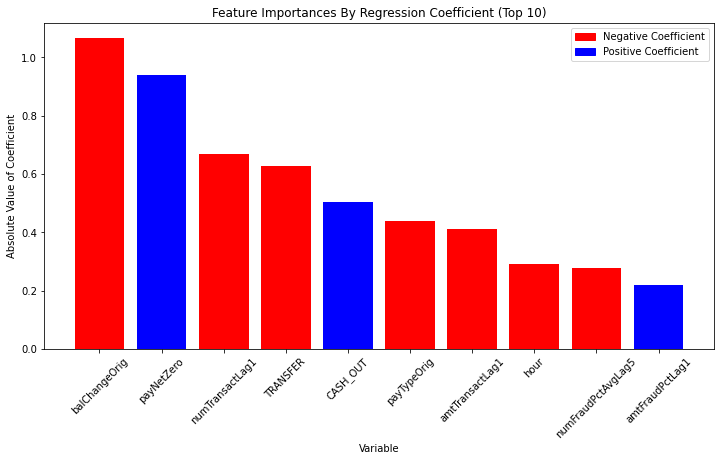

In [66]:
topN = 10
top_results = coef_results.sort_values('abs_coefficients', ascending=False).iloc[:topN]

plt.figure(figsize=(12,6))
plt.bar(top_results['variable_name'], top_results['abs_coefficients'], color = ['red' if coef < 0 else 'blue' for coef in top_results['coefficients']])
plt.title(f"Feature Importances By Regression Coefficient (Top {topN})")
plt.ylabel("Absolute Value of Coefficient")
plt.xlabel('Variable')
plt.xticks(rotation = 45)

colors = {'Negative Coefficient':'red', 'Positive Coefficient':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

#### Logit Model Cross-Validation Analysis

In [10]:
logit_results_dict = defaultdict(list)
for i, mean_score in enumerate(logit_results.cv_results_['mean_test_score']):
    logit_results_dict['penalty'].append(logit_results.cv_results_['params'][i]['penalty'])
    logit_results_dict['C'].append(logit_results.cv_results_['params'][i].get('C',None))
    logit_results_dict['l1_ratio'].append(logit_results.cv_results_['params'][i].get('l1_ratio',None))
    logit_results_dict['mean_score'].append(mean_score)
    logit_results_dict['rank'].append(logit_results.cv_results_['rank_test_score'][i])
    
logit_results_df = pd.DataFrame(logit_results_dict)
display(logit_results_df)
print(f'Max Score: {max(logit_results_df["mean_score"]):.6f}')
print(f'Min Score: {min(logit_results_df["mean_score"]):.6f}')

,penalty,C,l1_ratio,mean_score,rank
0,none,NaN,NaN,0.987682,14
1,l1,0.001,NaN,0.982529,26
2,l2,0.001,NaN,0.987119,22
3,l1,0.010,NaN,0.987466,21
4,l2,0.010,NaN,0.987724,1
5,l1,0.100,NaN,0.987690,5
6,l2,0.100,NaN,0.987686,7
7,l1,1.000,NaN,0.987682,15
8,l2,1.000,NaN,0.987683,10
9,l1,10.000,NaN,0.987684,9


Max Score: 0.987724
Min Score: 0.982529


In [11]:
# Mean Score by Varying Cost Parameters
logit_results_df.groupby('C')['mean_score'].mean()

C
0.001     0.985092
0.010     0.987604
0.100     0.987690
1.000     0.987682
10.000    0.987682
Name: mean_score, dtype: float64

#### Testing Performance

In [6]:
with open("models/logistic-regression-gridsearchcv-results.pkl", "rb") as output_file:
    logit_results = pickle.load(output_file)

clfs = [logit_results]
clf_names = ['logit']

compare_models(
    clfs,
    clf_names,
    data_dict['X_train_scaled'],
    data_dict['y_train'],
    data_dict['X_test_scaled'],
    data_dict['y_test'],
)

,logit
accuracy_test,0.999486
accuracy_train,0.999480
precision_test,0.943182
precision_train,0.949951
recall_test,0.410891
recall_train,0.399670
roc_auc_test,0.986203
roc_auc_train,0.988007
